In [5]:
import pandas as pd
import scipy.stats as linregress
import numpy as np
import matplotlib.pyplot as plt
import json 
import requests
import time
import random

In [3]:
url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service'
endpoint = '/v1/accounting/mts/mts_table_3'

In [ ]:
#Empty DataFrame that Holds info from fiscal Treasury Website
all_data = pd.DataFrame()

for i in range(0,65):
    Connected = False
    while Connected == False:
        try:
            params = f'?page[number]={i+1}&page[size]=100'
            outlay_url = url+endpoint+params
            response = requests.get(outlay_url).json()
            labels = response['meta']['labels']
            dataTypes = response['meta']['dataTypes']
            data = response['data']
            Connected = True
        except requests.RequestException as e:
            print(f"Failed to fetch data for page {i + 1}: {e}\nTrying again...")
            time.sleep(5)
    for column, dtype in dataTypes.items():
        if dtype == 'DATE':
            dataTypes[column] = 'datetime64[ns]'
        elif dtype in ('YEAR', 'MONTH', 'QUARTER', 'DAY', 'INTEGER'):
            dataTypes[column] = 'int'
        elif dtype == 'STRING':
            dataTypes[column] = 'string'
        elif dtype == 'CURRENCY':
            dataTypes[column] = 'float'
    temp = pd.DataFrame(data, columns=list(labels.keys()))
    temp = temp.loc[temp['parent_id'] != 'null']
    temp = temp.loc[temp['current_month_rcpt_outly_amt'] != 'null']
    temp = temp.loc[temp['current_year_budget_est_amt'] != 'null']
    for column, dtype in dataTypes.items():
        if column in temp.columns:
            temp[column] = temp[column].astype(dtype)
    temp.rename(columns=labels, inplace=True)
    all_data = pd.concat([all_data, temp], axis=0, ignore_index=True)
    time.sleep(6)
    print(f'completed page {i+1}')

completed page 1
completed page 2
completed page 3


In [ ]:
all_data.to_csv('../Data/Outlay_Data.csv', index=False)

In [4]:
gov_data_v3 = pd.read_csv('../Data/Outlay_Data.csv')
gov_data_v3['Calendar Year'].unique

<bound method Series.unique of 0       2015
1       2015
2       2015
3       2015
4       2015
        ... 
5703    2024
5704    2024
5705    2024
5706    2024
5707    2024
Name: Calendar Year, Length: 5708, dtype: int64>

In [5]:
gov_data_2022 = gov_data_v3.loc[gov_data_v3['Calendar Year'] == 2022]
outlays_2022 = gov_data_2022.loc[gov_data_v3['Classification Description'] == 'Total Outlays']
outlays_sum_2022 = outlays_2022['Current Month Receipt or Outlay Amount'].sum()/1000000000
receipts_2022 = gov_data_2022.loc[gov_data_v3['Classification Description'] == 'Total Receipts']
receipts_sum_2022 = receipts_2022['Current Month Receipt or Outlay Amount'].sum()/1000000000
print(outlays_sum_2022)
print(receipts_sum_2022)

6289.0309986899
4869.953771106111


In [7]:
#for i in range(len(gov_data_2023))
gov_data_2022["Classification Description"].unique()
receipt_list = ['Individual Income Taxes', 'Corporation Income Taxes',
       'Employment and General Retirement (Off-Budget)',
       'Employment and General Retirement (On-Budget)',
       'Unemployment Insurance', 'Other Retirement', 'Excise Taxes',
       'Estate and Gift Taxes', 'Customs Duties',
       'Miscellaneous Receipts']
outlay_list = ['Legislative Branch', 'Judicial Branch',
       'Department of Agriculture', 'Department of Commerce',
       'Department of Defense--Military Programs',
       'Department of Education', 'Department of Energy',
       'Department of Health and Human Services',
       'Department of Homeland Security',
       'Department of Housing and Urban Development',
       'Department of the Interior', 'Department of Justice',
       'Department of Labor', 'Department of State',
       'Department of Transportation',
       'Interest on Treasury Debt Securities (Gross)', 'Other',
       'Department of Veterans Affairs', 'Corps of Engineers',
       'Other Defense Civil Programs', 'Environmental Protection Agency',
       'Executive Office of the President',
       'International Assistance Programs',
       'National Aeronautics and Space Administration',
       'National Science Foundation', 'Office of Personnel Management',
       'Small Business Administration', 'Social Security Administration',
       'Independent Agencies']
total_deficit_list = ['Surplus (+) or Deficit (-)','Total Outlays','Total Receipts']

In [9]:
gov_groups_2022 = gov_data_2022.groupby("Classification Description").sum()
gov_groups_2022 = gov_groups_2022[['Current Month Receipt or Outlay Amount']]
gov_receipt_2022 = gov_groups_2022.loc[gov_groups_2022.index.isin(receipt_list)]
gov_outlay_2022 = gov_groups_2022.loc[gov_groups_2022.index.isin(outlay_list)]
total_deficit_2022 = gov_groups_2022.loc[gov_groups_2022.index.isin(total_deficit_list)]

gov_receipt_2022 = gov_receipt_2022 / 1000000000
gov_receipt_2022 = gov_receipt_2022.rename(columns={'Current Month Receipt or Outlay Amount': 'Yearly Receipt ($ Billions)'})
gov_receipt_2022['Percentage'] = (gov_receipt_2022['Yearly Receipt ($ Billions)'] / gov_receipt_2022['Yearly Receipt ($ Billions)'].sum()) * 100
gov_receipt_2022 =  gov_receipt_2022.sort_values(by="Yearly Receipt ($ Billions)", ascending=False)
gov_receipt_2022.to_csv("../Output/US_Receipts_2022.csv")

gov_outlay_2022 = gov_outlay_2022 / 1000000000
gov_outlay_2022 = gov_outlay_2022.rename(columns={'Current Month Receipt or Outlay Amount': 'Yearly Outlay ($ Billions)'})
gov_outlay_2022['Percentage'] = (gov_outlay_2022['Yearly Outlay ($ Billions)'] / gov_outlay_2022['Yearly Outlay ($ Billions)'].sum()) * 100
gov_outlay_2022 =  gov_outlay_2022.sort_values(by="Yearly Outlay ($ Billions)", ascending=False)
gov_outlay_2022.to_csv("../Output/US_Outlays_2022.csv")

total_deficit_2022 = total_deficit_2022 / 1000000000
total_deficit_2022 = total_deficit_2022.rename(columns={'Current Month Receipt or Outlay Amount': 'Yearly Deficit/Surplus ($ Billions)'})
total_deficit_2022.to_csv("../Output/US_Deficit_2022.csv")

gov_receipt_2022

,Yearly Receipt ($ Billions),Percentage
Classification Description,,
Individual Income Taxes,2601.335658,53.416024
Employment and General Retirement (Off-Budget),1085.816850,22.296246
Corporation Income Taxes,431.585146,8.862202
Employment and General Retirement (On-Budget),354.083161,7.270770
Miscellaneous Receipts,113.450896,2.329609
Customs Duties,98.021810,2.012787
Excise Taxes,88.172303,1.810537
Unemployment Insurance,58.236257,1.195828
Estate and Gift Taxes,32.969946,0.677007


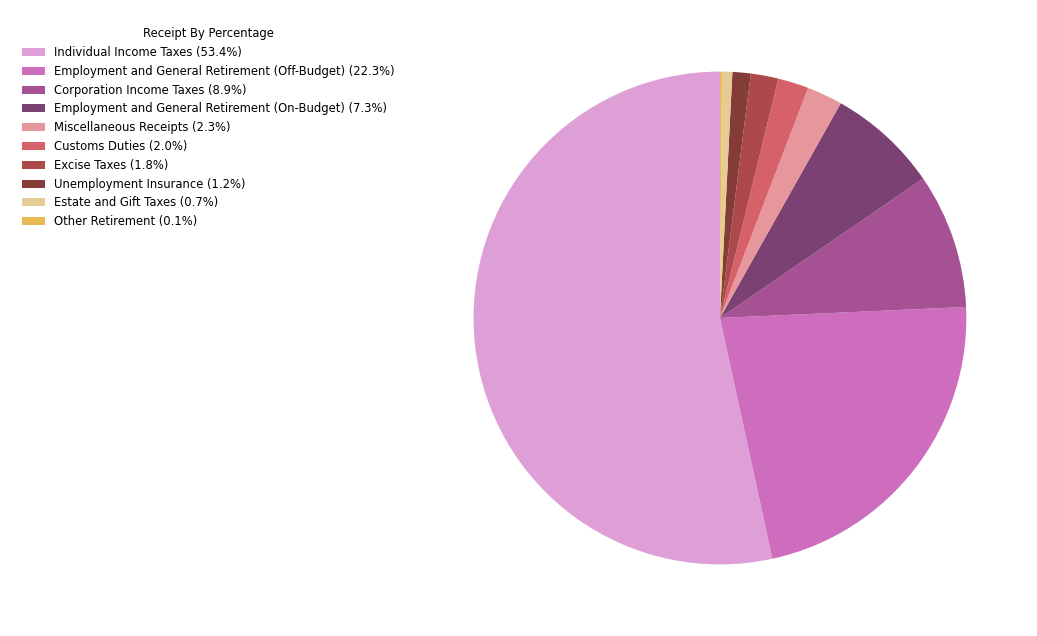

In [12]:
plt.figure(figsize=(8, 8))

colors = plt.get_cmap('tab20b_r').colors

plt.pie(gov_receipt_2022["Yearly Receipt ($ Billions)"], labels=None, autopct=None, startangle=90, colors = colors)

labels = gov_receipt_2022.index + ' (' + gov_receipt_2022["Percentage"].round(1).astype(str) + '%)'

plt.legend(labels=labels, title="Receipt By Percentage", loc="best", fontsize='small', bbox_to_anchor=(0, 1), frameon=False, title_fontsize='small', borderpad=1)
plt.show()

In [13]:
gov_outlay_2022

,Yearly Outlay ($ Billions),Percentage
Classification Description,,
Department of Health and Human Services,1621.050817,24.991123
Social Security Administration,1303.097170,20.089353
Interest on Treasury Debt Securities (Gross),774.679344,11.942937
Department of Defense--Military Programs,733.683846,11.310925
Department of Education,655.457079,10.104932
Department of Veterans Affairs,269.921555,4.161278
Department of Agriculture,243.894647,3.760031
Other,171.602171,2.645525
Department of Transportation,115.654587,1.783003


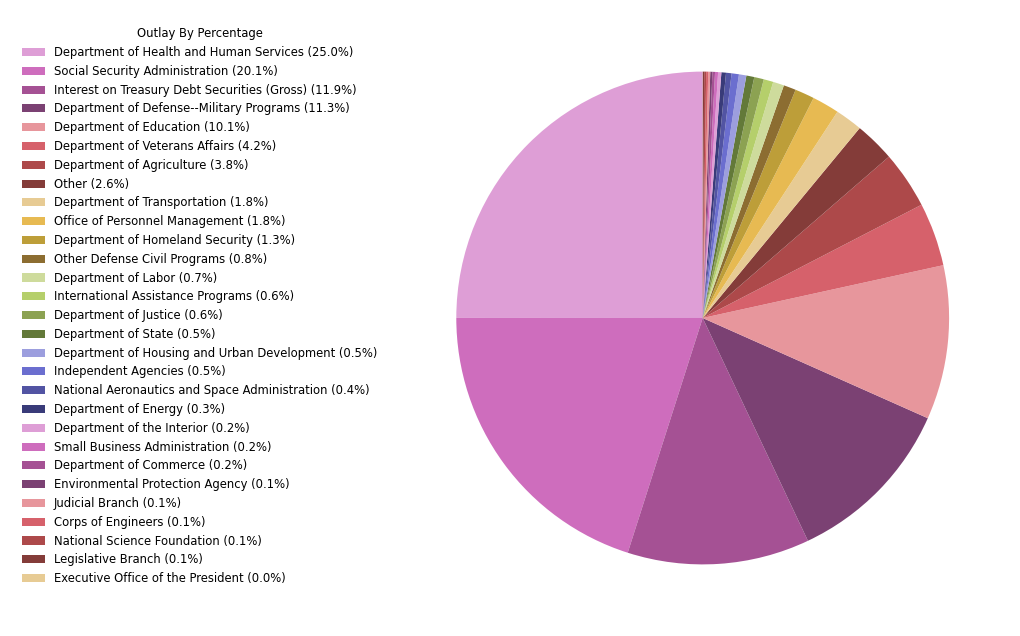

In [14]:
plt.figure(figsize=(8, 8))

colors = plt.get_cmap('tab20b_r').colors

plt.pie(gov_outlay_2022["Yearly Outlay ($ Billions)"], labels=None, autopct=None, startangle=90, colors = colors)

labels = gov_outlay_2022.index + ' (' + gov_outlay_2022["Percentage"].round(1).astype(str) + '%)'

plt.legend(labels=labels, title="Outlay By Percentage", loc="best", fontsize='small',bbox_to_anchor=(0, 1), frameon=False, title_fontsize='small', borderpad=1)

In [16]:
gov_data_def = gov_data_v3.groupby(["Classification Description", "Record Date"]).sum()
gov_data_def = gov_data_def[["Current Month Receipt or Outlay Amount"]]
total_deficit = gov_data_def.loc[gov_data_def.index.get_level_values(0).isin(total_deficit_list)]
total_deficit = total_deficit.unstack(level=0)
total_deficit.columns = total_deficit.columns.get_level_values(1)
total_deficit = total_deficit/1000000000
total_deficit.to_csv("../Output/Total_Deficit-Outlays-Receipts.csv")
total_deficit

Classification Description,Surplus (+) or Deficit (-),Total Outlays,Total Receipts
Record Date,,,
2015-03-31,-52.910060,287.097398,234.187338
2015-04-30,156.714078,315.087162,471.801241
2015-05-31,-82.385278,294.771106,212.385827
2015-06-30,51.775764,291.157289,342.933053
2015-07-31,-149.186766,374.680134,225.493367
...,...,...,...
2024-02-29,-296.274648,567.400717,271.126069
2024-03-31,-236.456824,568.547833,332.091009
2024-04-30,209.529307,566.668787,776.198093


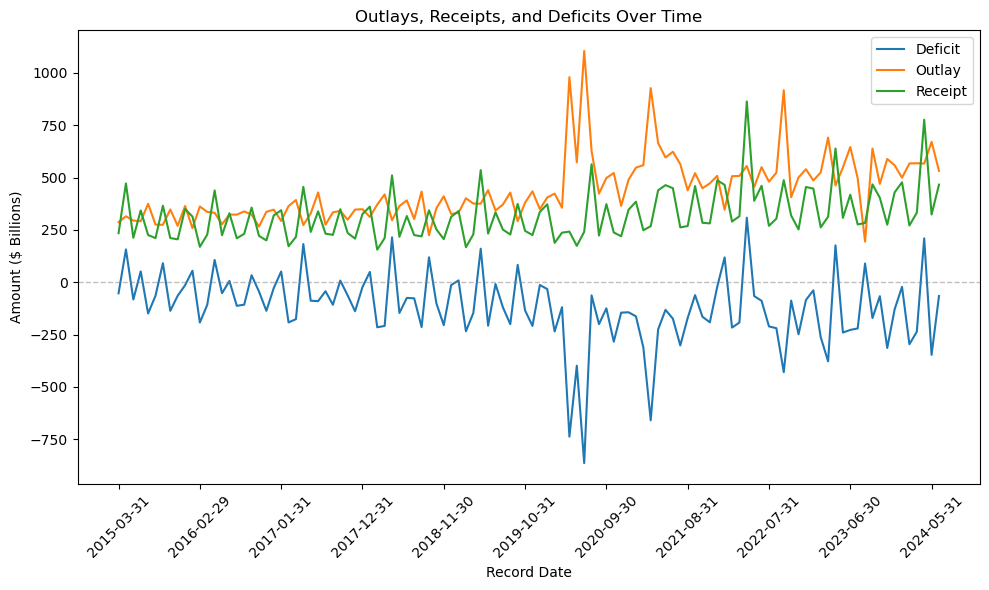

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(total_deficit.index, total_deficit['Surplus (+) or Deficit (-)'], label='Deficit')
plt.plot(total_deficit.index, total_deficit['Total Outlays'], label='Outlay')
plt.plot(total_deficit.index, total_deficit['Total Receipts'], label='Receipt')

# Adding titles and labels
plt.title('Outlays, Receipts, and Deficits Over Time')
plt.xlabel('Record Date')
plt.ylabel('Amount ($ Billions)')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha = .5)

# Rotating the x-axis labels for better readability
num_ticks = 10
plt.xticks(ticks=total_deficit.index[::len(total_deficit.index)//num_ticks], rotation=45)

# Adding a legend
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.savefig("../Output/Outlays-Receipts-Deficits_Overtime.png")
plt.show()

In [18]:
from splinter import Browser
from bs4 import BeautifulSoup

In [19]:
browser = Browser('chrome')
investopedia_url = 'https://www.investopedia.com/us-national-debt-by-year-7499291'
browser.visit(investopedia_url)
html = browser.html
soup = BeautifulSoup(html, 'html.parser')

In [20]:
debt_dict = []
table = soup.find('tbody')
sections = table.find_all('tr')
for section in sections:
    s = section.find_all('td')
    year = s[0].text
    debt = s[1].text
    debt_section = {'year':year,'debt ($ Billions)':debt}
    debt_dict.append(debt_section)

In [21]:
debt_data = pd.DataFrame(debt_dict)
debt_data

,year,debt ($ Billions)
0,1929,$17
1,1930,$16
2,1931,$17
3,1932,$20
4,1933,$23
...,...,...
90,2019,"$22,719"
91,2020,"$26,945"
92,2021,"$28,428"
93,2022,"$30,928"


In [22]:
debt_data['year'] = debt_data['year'].astype(int)
debt_data['debt ($ Billions)'] = debt_data['debt ($ Billions)'].astype(str) \
    .str.replace('$', '') \
    .str.replace(',', '') \
    .apply(pd.to_numeric, errors='coerce')
debt_data.dtypes

year                 int32
debt ($ Billions)    int64
dtype: object

In [23]:
debt_data

,year,debt ($ Billions)
0,1929,17
1,1930,16
2,1931,17
3,1932,20
4,1933,23
...,...,...
90,2019,22719
91,2020,26945
92,2021,28428
93,2022,30928


In [24]:
browser.quit()

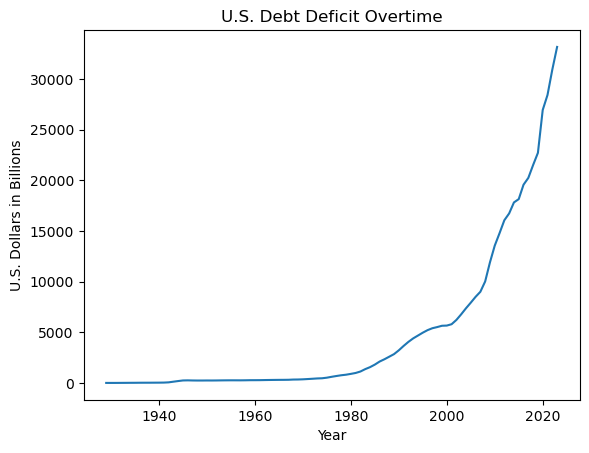

In [25]:
plt.plot(debt_data['year'], debt_data['debt ($ Billions)'])
plt.title("U.S. Debt Deficit Overtime")
plt.xlabel("Year")
plt.ylabel("U.S. Dollars in Billions")
plt.savefig("../Output/Deficits_Overtime.png")
plt.show()

In [26]:
debt_data.to_csv("../Output/US_debt_overtime.csv")

In [31]:
t_bonds_list = ['Surplus (+) or Deficit (-)', 'Interest on Treasury Debt Securities (Gross)']
gov_data_def_02 = gov_data_v3.groupby(["Classification Description", "Record Date"]).sum()
gov_data_def_02 = gov_data_def_02[["Current Month Receipt or Outlay Amount"]]
t_bonds = gov_data_def_02.loc[gov_data_def_02.index.get_level_values(0).isin(t_bonds_list)]
t_bonds = t_bonds.unstack(level=0)
t_bonds.columns = t_bonds.columns.get_level_values(1)
t_bonds = t_bonds/1000000000
t_bonds['Surplus (+) or Deficit (-)'] = t_bonds['Surplus (+) or Deficit (-)'] * -1
t_bonds = t_bonds.rename(columns={'Interest on Treasury Debt Securities (Gross)': 'Treasury Bonds', 'Surplus (+) or Deficit (-)': 'Deficit'})
t_bonds.to_csv("../Output/Treasury_Bonds.csv")
t_bonds

Classification Description,Treasury Bonds,Deficit
Record Date,,
2015-03-31,13.888687,52.910060
2015-04-30,31.782159,-156.714078
2015-05-31,32.692847,82.385278
2015-06-30,93.014301,-51.775764
2015-07-31,32.394094,149.186766
...,...,...
2024-02-29,76.161872,296.274648
2024-03-31,88.653867,236.456824
2024-04-30,102.439812,-209.529307


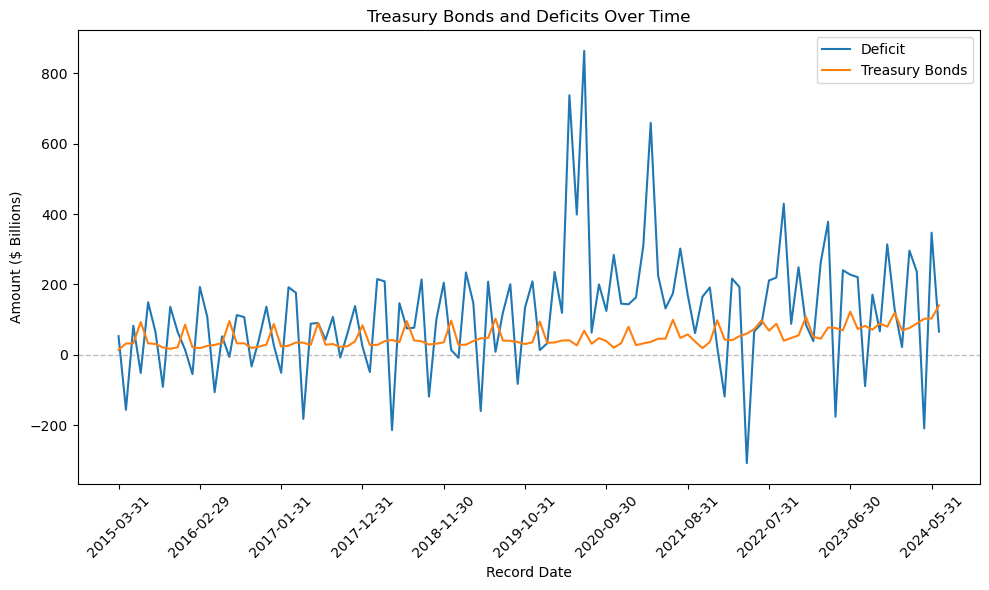

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(t_bonds.index, t_bonds['Deficit'], label='Deficit')
plt.plot(t_bonds.index, t_bonds['Treasury Bonds'], label='Treasury Bonds')

plt.title('Treasury Bonds and Deficits Over Time')
plt.xlabel('Record Date')
plt.ylabel('Amount ($ Billions)')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha = .5)

# Rotating the x-axis labels for better readability
num_ticks = 10
plt.xticks(ticks=total_deficit.index[::len(total_deficit.index)//num_ticks], rotation=45)

# Adding a legend
plt.legend()

# Displaying the plot
plt.tight_layout()

plt.savefig("../Output/Treasury_Bonds_Deficits_Overtime.png")
plt.show()

In [37]:
print(t_bonds['Treasury Bonds'].mean())
print(t_bonds['Deficit'].mean())

51.66450283493053
118.81515119522341


In [10]:
base_url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/'
endpoint = 'v2/accounting/od/debt_outstanding'

In [13]:
all_data = pd.DataFrame()

for i in range(0,3):
    Connected = False
    while Connected == False:
        try:
            params = f'?page[number]={i+1}&page[size]=100'
            url = base_url+endpoint+params
            response = requests.get(url).json()
            labels = response['meta']['labels']
            dataTypes = response['meta']['dataTypes']
            data = response['data']
            Connected = True
        except requests.RequestException as e:
            print(f"Failed to fetch data for page {i + 1}: {e}\nTrying again...")
            time.sleep(5)
    for column, dtype in dataTypes.items():
        if dtype == 'DATE':
            dataTypes[column] = 'datetime64[ns]'
        elif dtype in ('YEAR', 'MONTH', 'QUARTER', 'DAY', 'INTEGER'):
            dataTypes[column] = 'int'
        elif dtype == 'STRING':
            dataTypes[column] = 'string'
        elif dtype == 'CURRENCY':
            dataTypes[column] = 'float'
    temp = pd.DataFrame(data, columns=list(labels.keys()))
    for column, dtype in dataTypes.items():
        if column in temp.columns:
            temp[column] = temp[column].astype(dtype)
    temp.rename(columns=labels, inplace=True)
    all_data = pd.concat([all_data, temp], axis=0, ignore_index=True)
    time.sleep(6)
    print(f'completed page {i+1}')

completed page 1
completed page 2
completed page 3


In [29]:
debt_data = all_data[['Debt Outstanding Amount', 'Calendar Year']]
debt_data = debt_data.loc[debt_data['Calendar Year']>= 1930]
debt_data['Debt Outstanding Amount'] = round(debt_data['Debt Outstanding Amount'] / 1000000000, 2)
debt_data.to_csv("../Output/US_debt_overtime.csv", index = False)
debt_data

,Debt Outstanding Amount,Calendar Year
141,16.19,1930
142,16.80,1931
143,19.49,1932
144,22.54,1933
145,27.05,1934
...,...,...
230,22719.40,2019
231,26945.39,2020
232,28428.92,2021
233,30928.91,2022


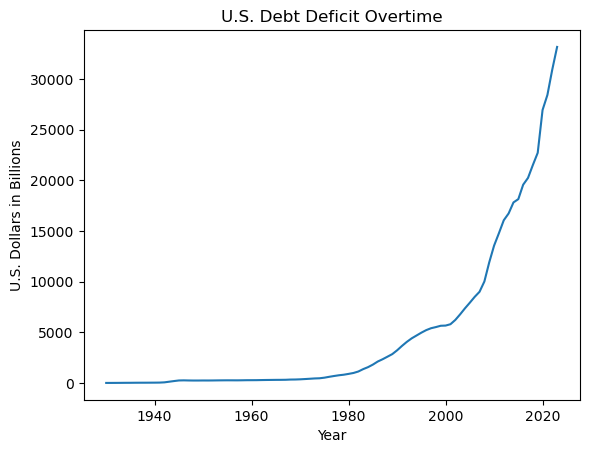

In [28]:
plt.plot(debt_data['Calendar Year'], debt_data['Debt Outstanding Amount'])
plt.title("U.S. Debt Deficit Overtime")
plt.xlabel("Year")
plt.ylabel("U.S. Dollars in Billions")
plt.savefig("../Output/Deficits_Overtime.png")
plt.show()


C:\Users\markb\AppData\Local\Temp\ipykernel_11532\1769002341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debt_data['Debt Outstanding Amount'] = round(debt_data['Debt Outstanding Amount'] / 1000000000, 2)


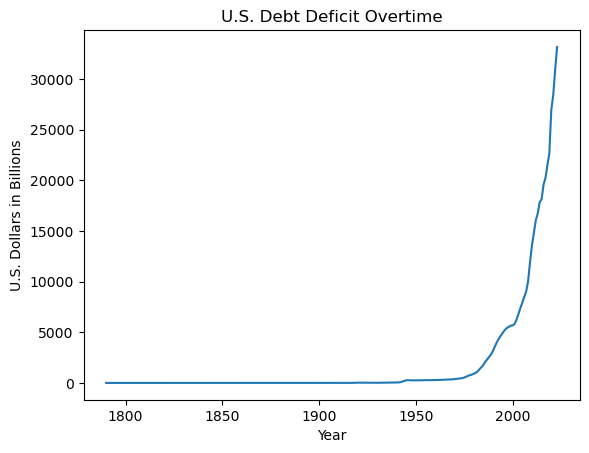